Simulate Data with GBM + Use BS to Measure Option Prices

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from datetime import datetime, timedelta

# --- Parameters ---
S0 = 100.0
mu = 0.08
sigma = 0.2
r = 0.05
q = 0.00
T = 1.0            # total horizon in years
N = 252            # time steps (e.g. daily)
dt = T / N
ticker = "General"
np.random.seed(42)

# strike grid: equal steps in strike price
K_values = np.arange(80, 141, 1)  

# --- 1. Simulate GBM Stock Price Path ---
dW = np.random.normal(0, np.sqrt(dt), N)
W = np.cumsum(dW)
t = np.linspace(dt, T, N)                       # time (years)
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
tau = T - t                                     # time to maturity (for a fixed expiry)

# calendar dates
start_date = datetime(2025, 1, 1)
time_index = [start_date + timedelta(days=i) for i in range(N)]
expiry = datetime(2025, 12, 31)

# --- helpers: Black–Scholes for one (S, K, tau) ---
def bs_call_put(S_t, K, r, q, sigma, tau_t):
    if tau_t <= 0:
        call = max(S_t - K, 0.0)
        put  = max(K - S_t, 0.0)
        return call, put

    sqrt_tau = np.sqrt(tau_t)
    d1 = (np.log(S_t / K) + (r - q + 0.5 * sigma**2) * tau_t) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau

    call = np.exp(-q * tau_t) * S_t * norm.cdf(d1) - np.exp(-r * tau_t) * K * norm.cdf(d2)
    put  = np.exp(-r * tau_t) * K * norm.cdf(-d2) - np.exp(-q * tau_t) * S_t * norm.cdf(-d1)
    return call, put

# --- 2. Build rows for call & put DataFrames ---
rows_call = []
rows_put = []

for i in range(N):
    S_t  = float(S[i])
    ttm  = float(tau[i])
    date = time_index[i]

    for K in K_values:        # loop over equal-step strikes
        call_p, put_p = bs_call_put(S_t, K, r, q, sigma, ttm)

        # small synthetic high/low bands
        high_c = call_p * np.random.uniform(1.01, 1.03)
        low_c  = call_p * np.random.uniform(0.97, 0.99)
        high_p = put_p  * np.random.uniform(1.01, 1.03)
        low_p  = put_p  * np.random.uniform(0.97, 0.99)

        rows_call.append({
            "time": date,
            "ticker": ticker,
            "price": S_t,
            "option_type": "C",
            "strike": float(K),
            "expiry": expiry,
            "option_p": call_p,
            "high": high_c,
            "low": low_c,
            "ttm": ttm,
            "moneyness": S_t - K,
            "riskfree": r * 100
        })

        rows_put.append({
            "time": date,
            "ticker": ticker,
            "price": S_t,
            "option_type": "P",
            "strike": float(K),
            "expiry": expiry,
            "option_p": put_p,
            "high": high_p,
            "low": low_p,
            "ttm": ttm,
            "moneyness": S_t - K,
            "riskfree": r * 100
        })

# --- 3. Create DataFrames with your column order ---
cols = ["time", "ticker", "price", "option_type", "strike",
        "expiry", "option_p", "high", "low", "ttm", "moneyness", "riskfree"]

df_call_bs = pd.DataFrame(rows_call)[cols].reset_index(drop=True)
df_put_bs  = pd.DataFrame(rows_put)[cols].reset_index(drop=True)

print("Call options sample:")
print(df_call_bs.head(), "\n")
print("Put options sample:")
print(df_put_bs.head())


Call options sample:
        time   ticker       price option_type  strike     expiry   option_p  \
0 2025-01-01  General  100.651725           C    80.0 2025-12-31  25.176650   
1 2025-01-01  General  100.651725           C    81.0 2025-12-31  24.322521   
2 2025-01-01  General  100.651725           C    82.0 2025-12-31  23.479301   
3 2025-01-01  General  100.651725           C    83.0 2025-12-31  22.647689   
4 2025-01-01  General  100.651725           C    84.0 2025-12-31  21.828370   

        high        low       ttm  moneyness  riskfree  
0  25.909223  24.792906  0.996032  20.651725       5.0  
1  24.769861  23.713354  0.996032  19.651725       5.0  
2  23.720853  22.829429  0.996032  18.651725       5.0  
3  23.261650  22.286983  0.996032  17.651725       5.0  
4  22.261277  21.380221  0.996032  16.651725       5.0   

Put options sample:
        time   ticker       price option_type  strike     expiry  option_p  \
0 2025-01-01  General  100.651725           P    80.0 2025-12-

In [8]:
df_call_bs.to_csv('/restricted/projectnb/sctad/Audrey/Quant_Research/Data/Calloption_BS_price.csv')
df_put_bs.to_csv('/restricted/projectnb/sctad/Audrey/Quant_Research/Data/Putoption_BS_price.csv')

Try the Transformer Model

In [1]:
from scipy.interpolate import splev, splrep
import time

import numpy as np
import pandas as pd


import QuantLib as ql
import math
from datetime import datetime, timedelta
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from scipy.stats import norm
from scipy.optimize import minimize 
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import gmean
from sklearn.model_selection import train_test_split
import warnings

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15,7)
plt.style.use("dark_background")
from matplotlib import cm

In [11]:
class FFT:
    def __init__(self, sigma, v0, kappa, rho, theta, s0, r, q, t, call):
        self.sigma = sigma
        self.v0 = v0
        self.kappa = kappa
        self.rho = rho
        self.theta = theta
        self.s0 = s0
        self.r = r
        self.q = q
        self.t = t
        self.call = call
    
    def heston_phi(self, u):
        lamb = (self.sigma**2 * (u**2 + 1j*u) 
                + (self.kappa - self.rho*self.sigma*1j*u)**2) ** 0.5

        omega = np.exp(
            np.log(self.s0)*1j*u
            + 1j*u*self.t*(self.r - self.q)
            + self.kappa*self.theta*self.t
              * (self.kappa - self.rho*self.sigma*1j*u) / self.sigma**2
        ) / (
            np.cosh(lamb*self.t/2)
            + (self.kappa - self.rho*self.sigma*1j*u)
              * np.sinh(lamb*self.t/2) / lamb
        ) ** (2*self.kappa*self.theta/self.sigma**2)

        phi = omega * np.exp(
            -(u**2 + 1j*u)*self.v0 /
            (lamb/np.tanh(lamb*self.t/2) 
             + self.kappa - self.rho*self.sigma*1j*u)
        )
        return phi
    
    def heston_fft(self, alpha, n, B, K):
        N = 2**n
        dv = B / N
        dk = 2*np.pi / (N * dv)

        beta = np.log(self.s0) - dk*N/2
        km = beta + np.arange(N) * dk
        v  = np.arange(N, dtype=np.complex128) * dv

        delta = np.zeros(N)
        delta[0] = 1

        x = np.zeros(N, dtype=np.complex128)

        for j in range(N):
            u = v[j] - (alpha + 1)*1j
            phi = self.heston_phi(u)
            x_j = phi * np.exp(-1j * beta * v[j])
            x_j *= (2 - delta[j]) * dv / (
                2 * (alpha + 1j*v[j]) * (alpha + 1 + 1j*v[j])
            )
            x[j] = x_j

        y1 = np.fft.fft(x).real
        y2 = np.exp(-alpha*km) / np.pi

        y = y1 * y2 * np.exp(-self.r*self.t)

        strike_grid = np.exp(km)
        price = np.interp(K, strike_grid, y)

        put = price + np.exp(-self.r*self.t)*K - self.s0

        return price if self.call == 1 else put

In [12]:
class heston_options:
    def __init__(self, df, call):
        self.df = df
        self.price = df['option_p']
        self.price.index = df.index
        self.K = df['strike']
        self.s0 = df['price']
        self.date = df.index
        self.rf = df['riskfree']
        self.maturity = df['expiry']
        self.ttm = df['ttm']
        self.delta = None
        self.call = call
        self.alpha = 0.8
        self.n = 13
        
    def __add__(self, heston_option2):
        new_option = heston_options(self.df, self.maturity, 2)
        new_option.price = new_option.price + heston_option2.price
        new_option.delta = self.delta + heston_option2.delta
        #new_option.option_type = 2
        return new_option
    
    def get_params(self):
        def Heston_params(maturity, alpha, n, df, call):
            def Heston_option_p(params, s0, r, q, t, alpha, n, B, K, call):
                p = FFT(params[0], params[1], params[2], params[3], params[4], s0, r, q, t, call).heston_fft(alpha, n, B, K)
                return p

            def Heston_price_diff_daily(params, maturity, alpha, n, df, call):
                output = 0
                for j in range(len(df)):
                    s0 = self.s0.values[j]
                    K = self.K.values[j]
                    t = self.ttm.values[j]
                    r = self.rf.values[j]
                    q = 0
                    B = K * 2.5
                    output += (Heston_option_p(params, s0, r, q, t, alpha, n, B, K, call) - self.price.values[j]) ** 2
                    if pd.isna(output):
                        print([params, s0, K, t, r, B])

                
                print(output)
                return output

            sigma = 0.3
            v0 = 0.3
            kappa = 0.5
            rho = -0.75
            theta = 0.5
            
            x0 = [sigma, v0, kappa, rho, theta]
            lower = [0.001, 0.001, 0.01, -1, 0.01]
            upper = [1, 1, 5, 1, 0.4]

            bounds = tuple(zip(lower, upper))
            #s = minimize(Heston_price_diff_daily, x0 = [sigma, v0, kappa, rho, theta], args = (maturity, alpha, n, df, 'Call'), bounds = bounds, tol = 0.1)
            s = minimize(Heston_price_diff_daily, x0 = [sigma, v0, kappa, rho, theta], args = (maturity, alpha, n, df, 'Call'), method = 'Powell', bounds = bounds)
            return s.x
            #print(Heston_price_diff_daily(x0, maturity, alpha, n, df, option_type))
        
        d_calibrate = self.df[(self.df['strike'].isin(self.df['strike'].value_counts().index[:3].tolist()))]
        self.sigma, self.v0, self.kappa, self.rho, self.theta = Heston_params(d_calibrate['expiry'], self.alpha, self.n, d_calibrate, self.call)
        #Heston_params(self.maturity, self.alpha, self.n, self.df, self.option_type)
        
        
    def cal_delta(self):
        warnings.filterwarnings("ignore")
        def Heston_option_p(params, s0, r, q, t, alpha, n, B, K, call):
            p = FFT(params[0], params[1], params[2], params[3], params[4], s0, r, q, t, call).heston_fft(alpha, n, B, K)
            return p
        Heston_call_price_up = np.zeros(self.df.shape[0])
        Heston_call_price_down = np.zeros(self.df.shape[0])
        params = [self.sigma, self.v0, self.kappa, self.rho, self.theta]
        diff = 0.01
        for i in tqdm(range(Heston_call_price_up.shape[0]), desc = "Loading"):
        #for i in range(Heston_call_price_up.shape[0]):
            Heston_call_price_up[i] = Heston_option_p(params, s0 = self.s0.iloc[i] + 0.01, r = self.rf.iloc[i] / 100, q = 0, t = self.ttm.iloc[i], alpha = self.alpha, n = self.n, B = self.K.iloc[i] * 2.5, K = self.K.iloc[i], call = self.call) 
            Heston_call_price_down[i] = Heston_option_p(params, s0 = self.s0.iloc[i] - 0.01, r = self.rf.iloc[i] / 100, q = 0, t = self.ttm.iloc[i], alpha = self.alpha, n = self.n, B = self.K.iloc[i] * 2.5, K = self.K.iloc[i], call = self.call) 

        self.delta = pd.DataFrame((Heston_call_price_up - Heston_call_price_down) / 2 / diff, index = self.df.index, columns = ['delta'])

    def set_params(self, sigma, v0, kappa, rho, theta):
        self.sigma = sigma
        self.v0 = v0
        self.kappa = kappa
        self.rho = rho
        self.theta = theta   

In [15]:
df = pd.read_csv("/restricted/projectnb/sctad/Audrey/Quant_Research/Data/MSFT_c_1hr_data.csv", index_col = 0)
df['time'] = pd.to_datetime(df['time'])
df['expiry'] = pd.to_datetime(df['expiry'])

df = df[~df['time'].dt.hour.isin([9, 10])]

df = df[df['expiry'] - df['time'] > timedelta(0)]

#df['range'] = (df['high'] - df['low']) / df['low'] * np.sqrt(60) * np.sqrt(24)
df

,time,ticker,price,option_type,strike,expiry,option_p,ttm,moneyness,riskfree
0,2024-01-02 11:00:00,MSFT,368.4200,C,280.0,2024-01-19 23:59:59,88.40,0.048059,88.4200,5.28
1,2024-01-02 11:00:00,MSFT,368.4200,C,395.0,2024-02-16 23:59:59,4.67,0.124772,-26.5800,5.28
2,2024-01-02 11:00:00,MSFT,368.4200,C,395.0,2024-01-19 23:59:59,0.46,0.048059,-26.5800,5.28
3,2024-01-02 11:00:00,MSFT,368.4200,C,390.0,2024-04-19 23:59:59,11.90,0.297374,-21.5800,5.28
4,2024-01-02 11:00:00,MSFT,368.4200,C,390.0,2024-03-15 23:59:59,8.40,0.201484,-21.5800,5.28
...,...,...,...,...,...,...,...,...,...,...
25558,2024-07-01 15:00:00,MSFT,453.7785,C,450.0,2024-08-16 23:59:59,18.70,0.127055,3.7785,5.27
25559,2024-07-01 15:00:00,MSFT,453.7785,C,450.0,2024-07-05 23:59:59,5.50,0.011986,3.7785,5.27
25560,2024-07-01 15:00:00,MSFT,453.7785,C,470.0,2024-07-12 23:59:59,0.78,0.031164,-16.2215,5.27
25561,2024-07-01 15:00:00,MSFT,453.7785,C,455.0,2024-07-19 23:59:59,6.70,0.050342,-1.2215,5.27


In [16]:
chosen_date = np.unique(df['time'])[0]

small_d = df[df['time'] == chosen_date]

small_d

,time,ticker,price,option_type,strike,expiry,option_p,ttm,moneyness,riskfree
0,2024-01-02 11:00:00,MSFT,368.42,C,280.0,2024-01-19 23:59:59,88.40,0.048059,88.42,5.28
1,2024-01-02 11:00:00,MSFT,368.42,C,395.0,2024-02-16 23:59:59,4.67,0.124772,-26.58,5.28
2,2024-01-02 11:00:00,MSFT,368.42,C,395.0,2024-01-19 23:59:59,0.46,0.048059,-26.58,5.28
3,2024-01-02 11:00:00,MSFT,368.42,C,390.0,2024-04-19 23:59:59,11.90,0.297374,-21.58,5.28
4,2024-01-02 11:00:00,MSFT,368.42,C,390.0,2024-03-15 23:59:59,8.40,0.201484,-21.58,5.28
...,...,...,...,...,...,...,...,...,...,...
78,2024-01-02 11:00:00,MSFT,368.42,C,372.5,2024-01-19 23:59:59,4.80,0.048059,-4.08,5.28
79,2024-01-02 11:00:00,MSFT,368.42,C,372.5,2024-01-05 23:59:59,1.50,0.009703,-4.08,5.28
80,2024-01-02 11:00:00,MSFT,368.42,C,370.0,2024-05-17 23:59:59,25.20,0.374087,-1.58,5.28
81,2024-01-02 11:00:00,MSFT,368.42,C,370.0,2024-03-15 23:59:59,17.14,0.201484,-1.58,5.28


In [24]:
from scipy.optimize import fmin
from scipy.optimize import minimize
from scipy.stats import norm


def ImpliedVolatilityCall(s, S, X, r, T, cm):
    d1 = ( (np.log(S/X)+(r+0.5*s[0]**2)*T) / (s[0]*np.sqrt(T)) )
    d2 = ( (np.log(S/X)+(r-0.5*s[0]**2)*T) / (s[0]*np.sqrt(T)) )
    of = (S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)) - cm
    val = of**2
    return(val)



def ImpliedVolatilityPut(s, S, X, r, T, pm):
    d1 = ( (np.log(S/X)+(r+0.5*s[0]**2)*T) / (s[0]*np.sqrt(T)) )
    d2 = ( (np.log(S/X)+(r-0.5*s[0]**2)*T) / (s[0]*np.sqrt(T)) )
    of = (X * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1) ) - pm
    val = of**2
    return(val)


def cal_iv(row):
    S = row['price']
    X = row['strike']
    r = row['riskfree'] / 100
    T = row['ttm']
    om = row['option_p']
    o_type = row['option_type']
    if o_type == 'C':
        return minimize(ImpliedVolatilityCall, [0.5], args = (S, X, r, T, om)).x[0]
        #return fmin(ImpliedVolatilityCall, [0.1], args = (S, X, r, T, om), disp = False)[0]
    else:
        return fmin(ImpliedVolatilityPut, [0.1], args = (S, X, r, T, om), disp = False)[0]

small_d['iv'] = small_d.progress_apply(cal_iv, axis = 1)
small_d

100%|██████████| 83/83 [00:00<00:00, 114.14it/s]
/scratch/1476777.1.w/ipykernel_3581596/2827847382.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_d['iv'] = small_d.progress_apply(cal_iv, axis = 1)


,time,ticker,price,option_type,strike,expiry,option_p,ttm,moneyness,riskfree,iv
0,2024-01-02 11:00:00,MSFT,368.42,C,280.0,2024-01-19 23:59:59,88.40,0.048059,88.42,5.28,0.225810
1,2024-01-02 11:00:00,MSFT,368.42,C,395.0,2024-02-16 23:59:59,4.67,0.124772,-26.58,5.28,0.249757
2,2024-01-02 11:00:00,MSFT,368.42,C,395.0,2024-01-19 23:59:59,0.46,0.048059,-26.58,5.28,0.200391
3,2024-01-02 11:00:00,MSFT,368.42,C,390.0,2024-04-19 23:59:59,11.90,0.297374,-21.58,5.28,0.227888
4,2024-01-02 11:00:00,MSFT,368.42,C,390.0,2024-03-15 23:59:59,8.40,0.201484,-21.58,5.28,0.231097
...,...,...,...,...,...,...,...,...,...,...,...
78,2024-01-02 11:00:00,MSFT,368.42,C,372.5,2024-01-19 23:59:59,4.80,0.048059,-4.08,5.28,0.192950
79,2024-01-02 11:00:00,MSFT,368.42,C,372.5,2024-01-05 23:59:59,1.50,0.009703,-4.08,5.28,0.210208
80,2024-01-02 11:00:00,MSFT,368.42,C,370.0,2024-05-17 23:59:59,25.20,0.374087,-1.58,5.28,0.249755
81,2024-01-02 11:00:00,MSFT,368.42,C,370.0,2024-03-15 23:59:59,17.14,0.201484,-1.58,5.28,0.242577


In [26]:
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(m = 1)


calculation_date = ql.Date(pd.to_datetime(chosen_date).day, pd.to_datetime(chosen_date).month, pd.to_datetime(chosen_date).year)
spot = small_d['price'].iloc[0]
ql.Settings.instance().evaluationDate = calculation_date

dividend_yield = ql.QuoteHandle(ql.SimpleQuote(0.0))
risk_free_rate = small_d['riskfree'].iloc[0] / 100
dividend_rate = 0.00
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))

In [30]:
def price_surface_matrix(df):
    d_subset = df[['strike', 'expiry', 'iv']].pivot(index="strike", columns="expiry", values="iv")

    d_subsubset = d_subset[(len(d_subset.columns) - d_subset.isna().sum(axis=1) > 3)]

    na_counts = d_subsubset.isna().sum()

    non_na_counts = d_subsubset.shape[0] - na_counts

    columns_with_most_non_na = non_na_counts.idxmax()
    largest_non_na_subset = d_subsubset.dropna(axis = 1, thresh = d_subsubset.shape[0] - 1)

    largest_non_na_subset = largest_non_na_subset.dropna(axis = 0)
    return largest_non_na_subset[(largest_non_na_subset != 0).all(axis = 1)]


d_subset = price_surface_matrix(small_d)

d_subset

expiry,2024-01-05 23:59:59,2024-01-12 23:59:59,2024-01-19 23:59:59,2024-02-16 23:59:59
strike,,,,
365.0,0.204949,0.198407,0.205136,0.259094
370.0,0.216922,0.205592,0.198346,0.262371
375.0,0.208588,0.199925,0.193359,0.254987
380.0,0.215466,0.193109,0.192619,0.251209
400.0,0.300960,0.237071,0.207427,0.249488


In [31]:
expiration_dates = [ql.Date(pd.to_datetime(i).day, pd.to_datetime(i).month, pd.to_datetime(i).year) for i in d_subset.columns]
strikes = [i for i in d_subset.index]
data = d_subset.T.values.tolist()

implied_vols = ql.Matrix(len(strikes), len(expiration_dates))


for i in range(implied_vols.rows()):
    for j in range(implied_vols.columns()):
        implied_vols[i][j] = data[j][i]
black_var_surface = ql.BlackVarianceSurface(
    calculation_date, calendar,
    expiration_dates, strikes,
    implied_vols, day_count)

strikes_grid = np.arange(strikes[0], strikes[-1], 5)


expiry = ((pd.to_datetime(d_subset.columns[-1]) - pd.to_datetime(chosen_date)).days) / 365 # years
implied_vols = [black_var_surface.blackVol(expiry, s)
                for s in strikes_grid] # can interpolate here
actual_data = data[-1] # cherry picked the data for given expiry (1 year)

In [32]:
# dummy parameters
v0 = 0.01; kappa = 0.5; theta = 0.5; rho = -0.35; sigma = 0.3;
#v0 = 0.02; kappa = 0.5; theta = 0.5; rho = -0.75; sigma = 0.3;

process = ql.HestonProcess(flat_ts, dividend_ts,
                           ql.QuoteHandle(ql.SimpleQuote(spot)),
                           v0, kappa, theta, sigma, rho)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model)
heston_helpers = []
black_var_surface.setInterpolation("bicubic")
one_year_idx = len(data) - 1 
date = expiration_dates[one_year_idx]
for j, s in enumerate(strikes):
    t = (date - calculation_date )
    p = ql.Period(t, ql.Days)
    sigma = data[one_year_idx][j]
    #sigma = black_var_surface.blackVol(t/365.25, s)
    helper = ql.HestonModelHelper(p, calendar, spot, s,
                                  ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                  flat_ts,
                                  dividend_ts)
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)
lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, lm,
                 ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model.params()

print ("\ntheta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % (theta, kappa, sigma, rho, v0))
avg = 0.0

print ("%15s %15s %15s %20s" % (
    "Strikes", "Market Value",
     "Model Value", "Relative Error (%)"))
print ("="*70)
for i, opt in enumerate(heston_helpers):
    err = (opt.modelValue()/opt.marketValue() - 1.0)
    print ("%15.2f %14.5f %15.5f %20.7f " % (
        strikes[i], opt.marketValue(),
        opt.modelValue(),
        100.0*(opt.modelValue()/opt.marketValue() - 1.0)))
    avg += abs(err)
avg = avg*100.0/len(heston_helpers)
print ("-"*70)
print ("Average Abs Error (%%) : %5.3f" % (avg))


theta = 0.716492, kappa = 0.000000, sigma = 0.746996, rho = -0.279802, v0 = 0.074385
        Strikes    Market Value     Model Value   Relative Error (%)
         365.00       12.72789        12.84658            0.9324784 
         370.00       15.29959        15.01458           -1.8628592 
         375.00       14.38561        14.38217           -0.0238830 
         380.00       12.05525        12.14448            0.7401908 
         400.00        5.82304         5.81910           -0.0675319 
----------------------------------------------------------------------
Average Abs Error (%) : 0.725


In [33]:
heston_call = heston_options(df, 1)

In [34]:
heston_call.set_params(sigma, v0, kappa, rho, theta)

In [35]:
print(f"sigma, v0, theta, kappa, rho for heston_call: {heston_call.sigma}, {heston_call.v0}, {heston_call.theta}, {heston_call.kappa}, {heston_call.rho}")


#print(f"sigma, v0, theta, kappa, rho for heston_call_2: {heston_call_2.sigma}, {heston_call_2.v0}, {heston_call_2.theta}, {heston_call_2.kappa}, {heston_call_2.rho}")



sigma, v0, theta, kappa, rho for heston_call: 0.7469959295787542, 0.07438481241939032, 0.7164917016013319, 2.6305132369284934e-07, -0.27980177037615306


In [36]:
heston_call.cal_delta()

Loading: 100%|██████████| 21924/21924 [1:35:22<00:00,  3.83it/s]


In [37]:
heston_call.df

,time,ticker,price,option_type,strike,expiry,option_p,ttm,moneyness,riskfree
0,2024-01-02 11:00:00,MSFT,368.4200,C,280.0,2024-01-19 23:59:59,88.40,0.048059,88.4200,5.28
1,2024-01-02 11:00:00,MSFT,368.4200,C,395.0,2024-02-16 23:59:59,4.67,0.124772,-26.5800,5.28
2,2024-01-02 11:00:00,MSFT,368.4200,C,395.0,2024-01-19 23:59:59,0.46,0.048059,-26.5800,5.28
3,2024-01-02 11:00:00,MSFT,368.4200,C,390.0,2024-04-19 23:59:59,11.90,0.297374,-21.5800,5.28
4,2024-01-02 11:00:00,MSFT,368.4200,C,390.0,2024-03-15 23:59:59,8.40,0.201484,-21.5800,5.28
...,...,...,...,...,...,...,...,...,...,...
25558,2024-07-01 15:00:00,MSFT,453.7785,C,450.0,2024-08-16 23:59:59,18.70,0.127055,3.7785,5.27
25559,2024-07-01 15:00:00,MSFT,453.7785,C,450.0,2024-07-05 23:59:59,5.50,0.011986,3.7785,5.27
25560,2024-07-01 15:00:00,MSFT,453.7785,C,470.0,2024-07-12 23:59:59,0.78,0.031164,-16.2215,5.27
25561,2024-07-01 15:00:00,MSFT,453.7785,C,455.0,2024-07-19 23:59:59,6.70,0.050342,-1.2215,5.27


In [38]:
def create_df_for_transformer(heston_call_object):
    d = heston_call_object.df.copy()
    d['delta'] = heston_call.delta.values
    
    d['expiry'] = pd.to_datetime(d['expiry']).dt.date

    d = d.dropna()

    grouped = d.groupby(['strike', 'expiry'])

    d['predict_delta'] = grouped['delta'].shift(-1)
    
    d['stock_return'] = grouped['price'].pct_change()
    
    d['option_return'] = grouped['option_p'].pct_change()
    
    d = d.sort_values(['expiry', 'strike', 'time'])

    d = d.dropna()
    
    return d.drop(['ticker', 'option_type', 'time'], axis = 1)

d_all = create_df_for_transformer(heston_call)
#d_all.index = []

In [39]:
d_all

,price,strike,expiry,option_p,ttm,moneyness,riskfree,delta,predict_delta,stock_return,option_return
174,369.4113,350.0,2024-01-05,19.80,0.009361,19.4113,5.28,0.977721,0.978326,0.002691,0.058824
194,369.5099,350.0,2024-01-05,19.85,0.009247,19.5099,5.28,0.978326,0.996548,0.000267,0.002525
117,367.5765,365.0,2024-01-05,5.35,0.009589,2.5765,5.28,0.668892,0.756104,-0.002290,0.049020
150,370.9488,365.0,2024-01-05,7.20,0.009475,5.9488,5.28,0.756104,0.841893,0.009174,0.345794
527,372.1816,365.0,2024-01-05,7.29,0.004110,7.1816,5.28,0.841893,0.848232,0.003323,0.012500
...,...,...,...,...,...,...,...,...,...,...,...
22005,406.3183,500.0,2025-03-21,9.90,0.806621,-93.6817,5.27,0.177185,0.306796,0.028095,0.000000
17214,395.6100,510.0,2025-03-21,9.70,0.905365,-114.3900,5.28,0.141733,0.288342,-0.064080,-0.440922
21080,430.8600,530.0,2025-03-21,8.15,0.828881,-99.1400,5.28,0.183028,0.166034,0.049819,0.116438
15613,422.1600,640.0,2025-03-21,2.76,0.932991,-217.8400,5.28,0.061227,0.061624,0.001281,0.000000


In [40]:
d_all.to_csv('/restricted/projectnb/sctad/Audrey/Quant_Research/Data/Transformer_matrix.csv')

In [6]:
d_all=pd.read_csv('/restricted/projectnb/sctad/Audrey/Quant_Research/Data/Transformer_matrix.csv', index_col=0)

In [7]:
d_all

,price,strike,expiry,option_p,ttm,moneyness,riskfree,delta,predict_delta,stock_return,option_return
174,369.4113,350.0,2024-01-05,19.80,0.009361,19.4113,5.28,0.977721,0.978326,0.002691,0.058824
194,369.5099,350.0,2024-01-05,19.85,0.009247,19.5099,5.28,0.978326,0.996548,0.000267,0.002525
117,367.5765,365.0,2024-01-05,5.35,0.009589,2.5765,5.28,0.668892,0.756104,-0.002290,0.049020
150,370.9488,365.0,2024-01-05,7.20,0.009475,5.9488,5.28,0.756104,0.841893,0.009174,0.345794
527,372.1816,365.0,2024-01-05,7.29,0.004110,7.1816,5.28,0.841893,0.848232,0.003323,0.012500
...,...,...,...,...,...,...,...,...,...,...,...
22005,406.3183,500.0,2025-03-21,9.90,0.806621,-93.6817,5.27,0.177185,0.306796,0.028095,0.000000
17214,395.6100,510.0,2025-03-21,9.70,0.905365,-114.3900,5.28,0.141733,0.288342,-0.064080,-0.440922
21080,430.8600,530.0,2025-03-21,8.15,0.828881,-99.1400,5.28,0.183028,0.166034,0.049819,0.116438
15613,422.1600,640.0,2025-03-21,2.76,0.932991,-217.8400,5.28,0.061227,0.061624,0.001281,0.000000


In [8]:
device = torch.device('cpu')

In [9]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, target_column):
        self.dataframe = dataframe
        #self.features = dataframe.drop(columns=[target_column]).values

        self.features = np.vstack(dataframe.drop(columns=[target_column]).values).astype(float)
        self.target = np.vstack(dataframe[target_column].values).astype(float)

        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.target = torch.tensor(self.target, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Dimensionality of the model
        self.seq_len = seq_len # Maximum sequence length
        self.dropout = nn.Dropout(dropout) # Dropout layer to prevent overfitting

        # Creating a positional encoding matrix of shape (seq_len, d_model) filled with zeros
        pe = torch.zeros(seq_len, d_model)

        # Creating a tensor representing positions (0 to seq_len - 1)
        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # Transforming 'position' into a 2D tensor['seq_len, 1']

        # Creating the division term for the positional encoding formula
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices in pe
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in pe
        pe[:, 1::2] = torch.cos(position * div_term)

        # Adding an extra dimension at the beginning of pe matrix for batch handling
        pe = pe.unsqueeze(0)

        # Registering 'pe' as buffer. Buffer is a tensor not considered as a model parameter
        self.register_buffer('pe', pe)

    def forward(self,x):
        # Addind positional encoding to the input tensor X
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x) # Dropout for regularization

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(MultiHeadAttention, self).__init__()
        self.multi_head_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        attn_output, _ = self.multi_head_attention(x, x, x)
        attn_output = self.norm(attn_output + x)  # Add & Norm
        return attn_output

In [12]:
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        
        #A linear layer for input
        self.input_linear = nn.Linear(input_dim, d_model)
        
        #Add the positional encoder for sequential feature
        self.positional_encoding = PositionalEncoding(d_model, batch_size, 0.2)
    
        #Add the multi-head attention for inter-feature relationship
        self.multihead_attention = MultiHeadAttention(d_model, nhead)
        
        #Tokenize the data for intermediate layer training
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        
        #Normal neural network 
        self.intermediate1 = nn.Linear(d_model, 64)
        self.intermediate2 = nn.Linear(64, d_model)
        
        #Output the prediction 
        self.output_linear = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_linear(x)
        x = self.positional_encoding.forward(x)
        x = self.multihead_attention.forward(x)
        x = self.transformer_encoder(x)
        x = torch.relu(self.intermediate1(x))
        x = self.intermediate2(x)
        x = self.output_linear(x[:, 0, :])  # Use the first token for regression output
        return x

In [13]:
def train(dataset_train, model, optimizer, criterion, train_loader, n_epochs = 100, state_dict = 'transformer_regression_model.pth'):    
    loss_record = []
    for epoch in range(n_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            #print(inputs)
            outputs = model(inputs.unsqueeze(1))  # Add sequence dimension
            #print(outputs)
            #print(criterion(outputs, targets))
            #print(torch.tensor((group['option_return'].shift(1).dropna().reset_index(drop = True))) * torch.tensor(outputs[:len(group['option_return'].shift(1).dropna().reset_index(drop = True))]))
            loss = criterion(outputs, targets) - torch.sum(torch.tensor((group['option_return'].shift(1).dropna().reset_index(drop = True))) * torch.tensor(outputs[:len(group['option_return'].shift(1).dropna().reset_index(drop = True))])) + torch.sum(torch.tensor((group['stock_return'].shift(1).dropna().reset_index(drop = True))))
            loss.backward()
            optimizer.step()
        loss_record.append(loss.item())
        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

    print('Training completed!')
    plt.figure()
    plt.plot(loss_record)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Save the model
    torch.save(model.state_dict(), state_dict)
    
    
def predict(model, test_loader, state_dict = 'transformer_regression_model.pth'):
    #loaded_model = TransformerRegressionModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim, dropout)
    model.load_state_dict(torch.load(state_dict))
    model.eval()

    # Prepare lists to store predictions and true values
    all_predictions = []
    all_targets = []

    # Predict on the test data
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs.unsqueeze(1))  # Add sequence dimension
            all_predictions.extend(outputs.numpy())
            all_targets.extend(targets.numpy())

    # Calculate the Mean Squared Error
    mse = mean_squared_error(all_targets, all_predictions)
    print(f'Test MSE: {mse}')
    plt.figure(figsize=(15,15))
    if len(all_targets) <= 30:
        #plt.plot(all_predictions, label = 'prediction')
        #plt.plot(all_targets, label = 'target')
        plt.scatter(all_predictions, all_targets)
        plt.xlabel("Predictions")
        plt.ylabel("Actual")
    else:
        #plt.hist(np.array(all_predictions) - np.array(all_targets), label = 'difference', bins = 20)
        plt.scatter(all_predictions, all_targets)
        plt.xlabel("Predictions")
        plt.ylabel("Actual")
        plt.ylim((0,1))
        plt.xlim((0,1))
        plt.axline([0, 0], [1, 1])
    #plt.legend()
    
    return np.array(all_predictions)

In [14]:
d_all

,price,strike,expiry,option_p,ttm,moneyness,riskfree,delta,predict_delta,stock_return,option_return
174,369.4113,350.0,2024-01-05,19.80,0.009361,19.4113,5.28,0.977721,0.978326,0.002691,0.058824
194,369.5099,350.0,2024-01-05,19.85,0.009247,19.5099,5.28,0.978326,0.996548,0.000267,0.002525
117,367.5765,365.0,2024-01-05,5.35,0.009589,2.5765,5.28,0.668892,0.756104,-0.002290,0.049020
150,370.9488,365.0,2024-01-05,7.20,0.009475,5.9488,5.28,0.756104,0.841893,0.009174,0.345794
527,372.1816,365.0,2024-01-05,7.29,0.004110,7.1816,5.28,0.841893,0.848232,0.003323,0.012500
...,...,...,...,...,...,...,...,...,...,...,...
22005,406.3183,500.0,2025-03-21,9.90,0.806621,-93.6817,5.27,0.177185,0.306796,0.028095,0.000000
17214,395.6100,510.0,2025-03-21,9.70,0.905365,-114.3900,5.28,0.141733,0.288342,-0.064080,-0.440922
21080,430.8600,530.0,2025-03-21,8.15,0.828881,-99.1400,5.28,0.183028,0.166034,0.049819,0.116438
15613,422.1600,640.0,2025-03-21,2.76,0.932991,-217.8400,5.28,0.061227,0.061624,0.001281,0.000000


In [15]:
group = d_all.groupby(['strike', 'expiry'])

In [17]:
for (strike, expiry), df in group:
    print(strike, expiry)
    print(df.head())
    break


220.0 2025-01-17
          price  strike      expiry  option_p       ttm  moneyness  riskfree  \
18292  394.6551   220.0  2025-01-17    182.11  0.716552   174.6551      5.28   

          delta  predict_delta  stock_return  option_return  
18292  0.988233       0.987565     -0.012671      -0.036659  


This line extracts the predict_delta time series for a given (strike, expiry) group, removes NaNs, and re-indexes it to a clean 0…N sequence for use in modeling.

In [18]:
group['predict_delta'].shift(0).dropna().reset_index(drop = True)

0        0.978326
1        0.996548
2        0.756104
3        0.841893
4        0.848232
           ...   
19243    0.306796
19244    0.288342
19245    0.166034
19246    0.061624
19247    0.062554
Name: predict_delta, Length: 19248, dtype: float64

In [19]:
torch.sum(torch.tensor((group['predict_delta'].shift(0).dropna().reset_index(drop = True) * group['option_return'].shift(1).dropna().reset_index(drop = True)).dropna()))

tensor(169.8667, dtype=torch.float64)

In [21]:
torch.tensor((group['option_return'].shift(1).dropna().reset_index(drop = True))) * torch.tensor((group['predict_delta'].shift(0).reset_index(drop = True)[:len(group['option_return'].shift(1).dropna().reset_index(drop = True))]))

tensor([ 0.0575,  0.0489,  0.2615,  ..., -0.1880, -0.1000,  0.0000],
       dtype=torch.float64)

In [23]:
d_train, d_test = train_test_split(d_all, test_size = 0.3, random_state = 1018)

target_col = 'predict_delta'

d_train = d_train.drop('expiry', axis = 1)
d_test = d_test.drop('expiry', axis = 1)

dataset_train = TrainDataset(d_train, target_column = target_col)
dataset_test = TrainDataset(d_test, target_column = target_col)

batch_size = 100

train_loader = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset_test, batch_size = batch_size, shuffle = True)

input_dim = d_train.shape[1] - 1
d_model = 128
nhead = 32
num_encoder_layers = 1
dim_feedforward = 128
output_dim = 1
dropout = 0.3
num_epochs = 100
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = TransformerRegressionModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/scratch/1569316.1.w/ipykernel_2142741/3011974054.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, targets) - torch.sum(torch.tensor((group['option_return'].shift(1).dropna().reset_index(drop = True))) * torch.tensor(outputs[:len(group['option_return'].shift(1).dropna().reset_index(drop = True))])) + torch.sum(torch.tensor((group['stock_return'].shift(1).dropna().reset_index(drop = True))))


Epoch 10/100, Loss: -13301.188924722144
Epoch 20/100, Loss: -11812.739049538424
Epoch 30/100, Loss: -12410.854492480175
Epoch 40/100, Loss: -13103.331973940818
Epoch 50/100, Loss: -12837.644231358227
Epoch 60/100, Loss: -13136.95073453274
Epoch 70/100, Loss: -13306.128020594842
Epoch 80/100, Loss: -13038.453975613797
Epoch 90/100, Loss: -12851.012798951731
Epoch 100/100, Loss: -13812.834465712673
Training completed!


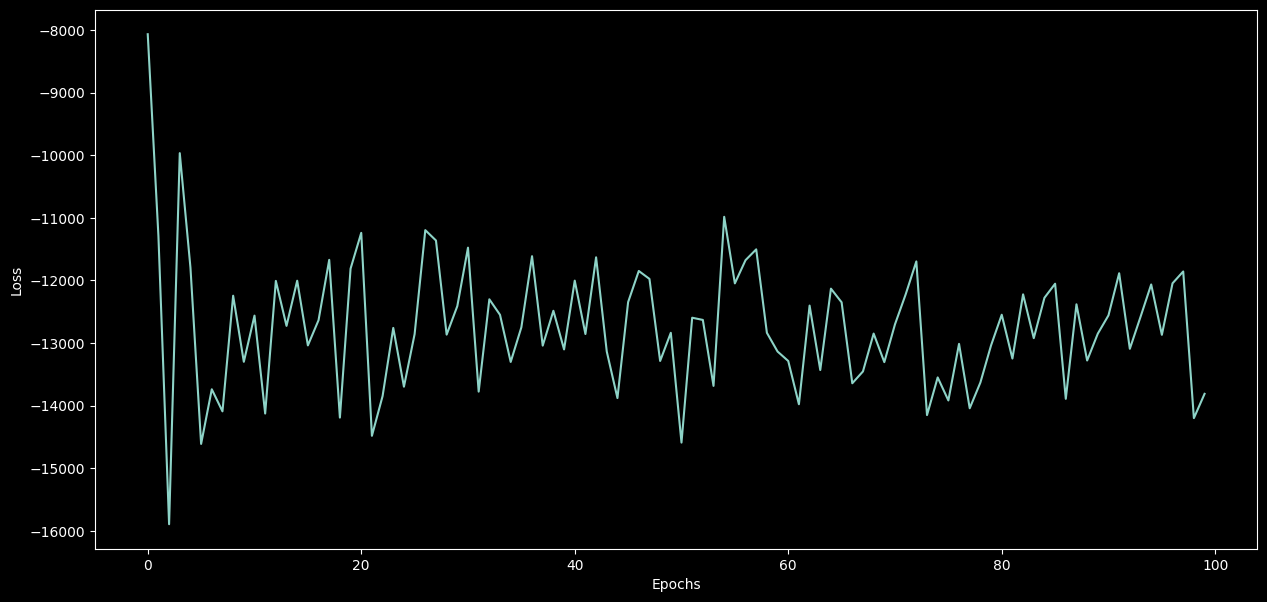

In [24]:
train(dataset_train, model, optimizer, criterion, train_loader, state_dict = 'transformer_regression_model.pth')

Test MSE: 0.015306636192428833


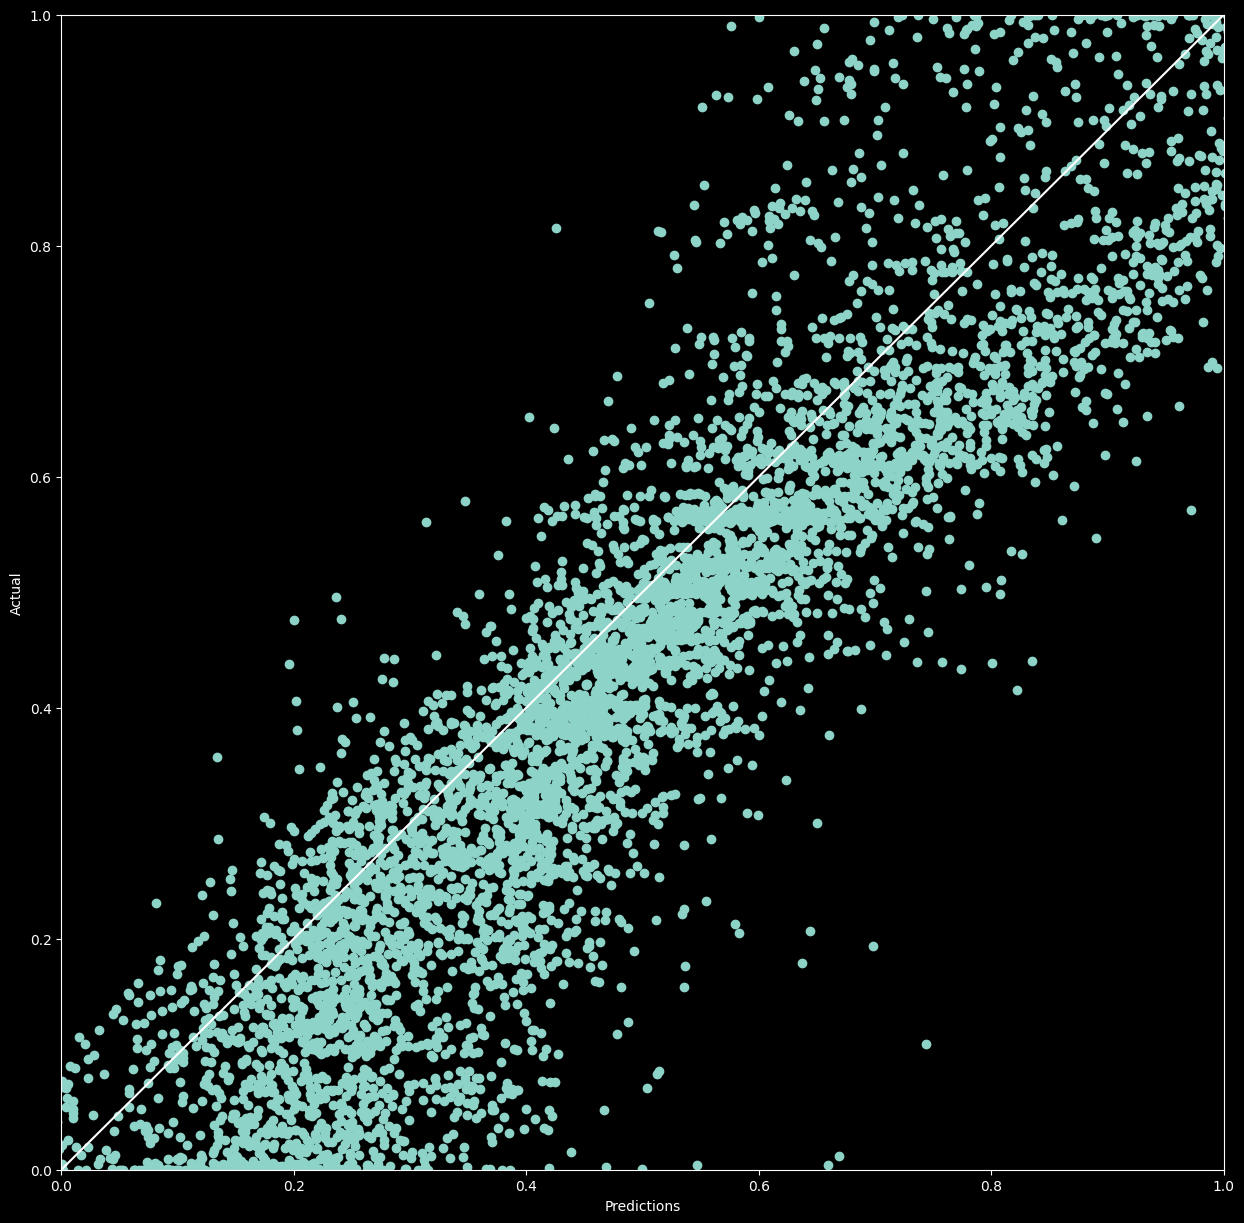

In [25]:
predictions = predict(model, test_loader, state_dict = 'transformer_regression_model.pth')

Reinforcement Learning